In [1]:
import torch
import math
from typing import Dict, List, Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.tensorboard.writer import SummaryWriter
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES #, NodeBool, NodeType, NodeParams, EdgeSubA, EdgeSubB, EdgeType
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataset1 import SketchDataset
from tqdm import tqdm
from torch.utils.checkpoint import checkpoint
from functools import partial
from IPython import display
import os
from torch.utils.data import random_split, TensorDataset, DataLoader

In [2]:
class GVAE(nn.Module):
    def __init__(self, device : torch.device):
        super().__init__()
        self.device = device
        self.node_dim = NODE_FEATURE_DIMENSION
        self.edge_dim = EDGE_FEATURE_DIMENSION
        self.graph_emb_dim = 1024

        self.encoder = TransformerEncoder(node_dim = self.node_dim, 
                                          edge_dim = self.edge_dim, 
                                          graph_emb_dim = self.graph_emb_dim, 
                                          num_tf_layers = 16,
                                          num_heads = 16,
                                          device = self.device
                                         )
        
        self.decoder = TransformerDecoder(node_dim = self.node_dim, 
                                          edge_dim = self.edge_dim, 
                                          graph_emb_dim = self.graph_emb_dim,
                                          num_tf_layers = 16,
                                          num_heads = 16, 
                                          device = self.device
                                         )
    
    def forward(self, nodes : Tensor, edges : Tensor):
        means, logvars = self.encoder(nodes, edges)
        pred_nodes, pred_edges = self.decoder( self.sample_latent(means, torch.exp(0.5 * logvars)) )

        return pred_nodes, pred_edges, means, logvars
    
    def sample_latent(self, mean : Tensor, standard_deviation : Tensor):
        return mean + standard_deviation * torch.randn(size=mean.size(), device = self.device)
    
    @torch.no_grad()
    def sample_graph(self) -> Tuple[Tensor, Tensor]:
        latent = torch.randn(size = (self.graph_emb_dim,), device = self.device)
        nodes, edges = self.decoder(latent)

        nodes[:,:,1:6] = torch.exp(nodes[:,:,1:6], dim = 2) # Softmax for primitive classes
        
        # softmax for constraints; Conceptual map => n1 (out) -> n2 (in) i.e. out_node, edge, in_node
        edges[:,:,:,0:4] = torch.exp(edges[:,:,:,0:4], dim = 3) # Softmax for out_node subnode type
        edges[:,:,:,4:8] = torch.exp(edges[:,:,:,4:8], dim = 3) # Softmax for in_node subnode type
        edges[:,:,:,8: ] = torch.exp(edges[:,:,:,8: ], dim = 3) # Softmax for edge type
        return torch.squeeze(nodes), torch.squeeze(edges)

class TransformerEncoder(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, graph_emb_dim : int, num_tf_layers: int, num_heads : int, device : torch.device): # perm_emb_dim: int,
        super().__init__()
        self.node_dim = node_dim # Number of features per node
        self.edge_dim = edge_dim # Number of features per edge
        self.graph_emb_dim = graph_emb_dim # Size of graph embedding vector
        self.num_nodes = MAX_NUM_PRIMITIVES # Number of nodes in each graph
        self.num_edges = self.num_nodes * self.num_nodes # Number of edges in each graph
        
        self.hidden_dim = 256
        self.num_tf_layers = num_tf_layers
        self.num_heads = num_heads

        self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.hidden_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1),
                                          nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1)
                                         )

        self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.hidden_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1),
                                          nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1)
                                         )
        
        self.tf_layers = nn.ModuleList([TransformerLayer(num_heads = self.num_heads, 
                                                         node_dim = self.hidden_dim,
                                                         edge_dim = self.hidden_dim, 
                                                         device = device
                                                        ) 
                                        for _ in range(self.num_tf_layers)])

        self.mlp_haggr_weights = nn.Sequential(nn.Linear(in_features = 3 * self.hidden_dim, out_features = 3 * self.hidden_dim, device = device),
                                              nn.LeakyReLU(.1),
                                            #   nn.Dropout(p = 0.1),
                                              nn.Linear(in_features = 3 * self.hidden_dim, out_features = 1, device = device),
                                              nn.Softmax(dim = 2),
                                            #   nn.Dropout(p = 0.1)
                                             )
        self.mlp_haggr_values = nn.Sequential(nn.Linear(in_features = 3 * self.hidden_dim, out_features = 3 * self.hidden_dim, device = device),
                                              nn.LeakyReLU(.1),
                                            #   nn.Dropout(p = 0.1),
                                              nn.Linear(in_features = 3 * self.hidden_dim, out_features = self.hidden_dim, device = device)
                                             )
        
        self.mlp_mean = nn.Sequential(nn.Linear(in_features = self.num_nodes * self.hidden_dim, out_features = self.graph_emb_dim, device = device),
                                      nn.LeakyReLU(.1),
                                    #   nn.Dropout(p = 0.1),
                                      nn.Linear(in_features = self.graph_emb_dim, out_features = self.graph_emb_dim, device = device)
                                     )
        self.mlp_logvar = nn.Sequential(nn.Linear(in_features = self.num_nodes * self.hidden_dim, out_features = self.graph_emb_dim, device = device),
                                        nn.LeakyReLU(.1),
                                        # nn.Dropout(p = 0.1),
                                        nn.Linear(in_features = self.graph_emb_dim, out_features = self.graph_emb_dim, device = device)
                                       )

    def forward(self, nodes : Tensor, edges : Tensor):
        nodes = self.mlp_in_nodes(nodes) # batch_size x num_nodes x mlp_node_hidden_dim
        edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x mlp_edge_hidden_dim

        for idx, layer in enumerate(self.tf_layers):
            nodes, edges = layer(nodes, edges) if idx % 8 == -1 else checkpoint(layer, nodes, edges, use_reentrant = False)
            # nodes, edges = layer(nodes, edges) # batch_size x num_nodes x tf_node_hidden_dim ; batch_size x num_nodes x num_nodes x tf_edge_hidden_dim
        
        # nodes = nodes.flatten(start_dim = 1) # batch_size x (num_nodes * node_dim)
        # edges = edges.flatten(start_dim = 1) # batch_size x (num_nodes * num_nodes * edge_dim)
        # graph_embs = torch.cat((nodes, edges), 1) # batch_size x (num_nodes * node_dim + num_nodes * num_nodes * edge_dim)
        
        # Soft attentional aggregation
        hstack = nodes.unsqueeze(3).expand(-1, -1, -1, self.num_nodes).permute(0, 1, 3, 2) # batch_size x num_nodes x num_nodes x hidden_dim
        vstack = hstack.permute(0, 2, 1, 3) # batch_size x num_nodes x num_nodes x hidden_dim
        graph_features = torch.cat(tensors = (hstack, vstack, edges), dim = 3) # batch_size x num_nodes x num_nodes x (3 * hidden_dim)
        del nodes
        del edges
        del hstack
        del vstack

        haggr_weights = self.mlp_haggr_weights(graph_features) # batch_size x num_nodes x num_nodes x 1
        graph_features = self.mlp_haggr_values(graph_features) # batch_size x num_nodes x num_nodes x hidden_dim

        graph_embs = (haggr_weights.permute(0, 1, 3, 2) @ graph_features).squeeze(2).flatten(start_dim = 1) # batch_size x (num_nodes * hidden_dim)
        del haggr_weights
        del graph_features

        means = self.mlp_mean(graph_embs)     # batch_size x graph_emb_dim
        logvars = self.mlp_logvar(graph_embs) # batch_size x graph_emb_dim
        del graph_embs

        return means, logvars     

class TransformerDecoder(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, graph_emb_dim : int, num_tf_layers : int, num_heads : int, device : torch.device):
        super().__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.graph_emb_dim = graph_emb_dim
        self.num_nodes = MAX_NUM_PRIMITIVES # Number of nodes in each graph
        self.num_edges = self.num_nodes * self.num_nodes # Number of edges in each graph

        self.temp_node_dim = 128
        self.hidden_dim = 256
        self.num_tf_layers = num_tf_layers
        self.num_heads = num_heads

        self.mlp_create_nodes = nn.Sequential(nn.Linear(in_features = self.graph_emb_dim, out_features = self.num_nodes * self.temp_node_dim, device = device),
                                              nn.LeakyReLU(.1),
                                            #   nn.Dropout(p = 0.1),
                                              nn.Linear(in_features = self.num_nodes * self.temp_node_dim, out_features = self.num_nodes * self.temp_node_dim, device = device),
                                              nn.LeakyReLU(.1),
                                            #   nn.Dropout(p = 0.1)
                                             )
        self.mlp_create_edges = nn.Sequential(nn.Linear(in_features = self.graph_emb_dim, out_features = self.num_edges * self.edge_dim, device = device),
                                              nn.LeakyReLU(.1),
                                            #   nn.Dropout(p = 0.1),
                                              nn.Linear(in_features = self.num_edges * self.edge_dim, out_features = self.num_edges * self.edge_dim, device = device),
                                              nn.LeakyReLU(.1),
                                            #   nn.Dropout(p = 0.1)
                                             )
        
        self.lin_node_transform = nn.Sequential(nn.Linear(in_features = self.temp_node_dim, out_features = self.hidden_dim, device = device),
                                                nn.LeakyReLU(.1),
                                                # nn.Dropout(p = 0.1),
                                                nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                                nn.LeakyReLU(.1),
                                                # nn.Dropout(p = 0.1)
                                               )
        self.lin_edge_transform = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.hidden_dim, device = device),
                                                nn.LeakyReLU(.1),
                                                # nn.Dropout(p = 0.1),
                                                nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                                nn.LeakyReLU(.1),
                                                # nn.Dropout(p = 0.1)
                                               )
        
        self.tf_layers = nn.ModuleList([TransformerLayer(num_heads = self.num_heads, 
                                                         node_dim = self.hidden_dim,
                                                         edge_dim = self.hidden_dim,
                                                         device = device
                                                        ) 
                                        for _ in range(self.num_tf_layers)])

        self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                           nn.LeakyReLU(.1),
                                        #    nn.Dropout(p = 0.1),
                                          #  nn.Linear(in_features = self.hidden_dim, out_features = node_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                          #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                          #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                           nn.Linear(in_features = self.hidden_dim, out_features = self.node_dim, device = device)
                                          )
        self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                           nn.LeakyReLU(.1),
                                        #    nn.Dropout(p = 0.1),
                                           nn.Linear(in_features = self.hidden_dim, out_features = self.edge_dim, device = device)
                                          )

    def forward(self, latents):
        nodes = torch.reshape(input = self.mlp_create_nodes(latents), shape = (-1, self.num_nodes, self.temp_node_dim))            # batch_size x num_nodes x mlp_node_out_dim
        edges = torch.reshape(input = self.mlp_create_edges(latents), shape = (-1, self.num_nodes, self.num_nodes, self.edge_dim)) # batch_size x num_nodes x num_nodes x mlp_edge_out_dim

        nodes = self.lin_node_transform(nodes) # batch_size x num_nodes x hidden_dim
        edges = self.lin_edge_transform(edges) # batch_size x num_nodes x num_nodes x hidden_dim

        for idx, layer in enumerate(self.tf_layers):
            # nodes, edges = checkpoint(layer, nodes, edges, use_reentrant = False)
            nodes, edges = layer(nodes, edges) if idx % 10 == -1 else checkpoint(layer, nodes, edges, use_reentrant = False)
            # nodes, edges = layer(nodes, edges) # batch_size x num_nodes x tf_node_hidden_dim ; # batch_size x num_nodes x num_nodes x tf_edge_hidden_dim
        
        nodes = self.mlp_out_nodes(nodes) # batch_size x num_nodes x node_dim
        edges = self.mlp_out_edges(edges) # batch_size x num_nodes x num_nodes x edge_dim

        # sigmoid and softmax for nodes
        nodes[:,:,0] = F.sigmoid(nodes[:,:,0])              # Sigmoid for isConstructible
        nodes[:,:,1:6] = F.softmax(nodes[:,:,1:6], dim = 2) # Softmax for primitive classes (i.e. line, circle, arc, point, none)
        
        # softmax for constraints; Conceptual map => n1 (out) -> n2 (in) i.e. out_node, edge, in_node
        edges[:,:,:,0:4] = F.softmax(edges[:,:,:,0:4], dim = 3) # Softmax for out_node subnode type
        edges[:,:,:,4:8] = F.softmax(edges[:,:,:,4:8], dim = 3) # Softmax for in_node subnode type
        edges[:,:,:,8: ] = F.softmax(edges[:,:,:,8: ], dim = 3) # Softmax for edge (aka constraint) type (i.e horizontal, vertical, etc...)

        return nodes, edges

# Graph Transformer Layer outlined by DiGress Graph Diffusion
class TransformerLayer(nn.Module):
    def __init__(self, num_heads : int, node_dim : int, edge_dim : int, device : torch.device):
        super().__init__()
        self.num_heads = num_heads
        self.node_dim = node_dim
        self.edge_dim = edge_dim

        self.attention_heads = MultiHeadAttention(node_dim = self.node_dim, edge_dim = self.edge_dim, num_heads = self.num_heads, device = device)

        self.layer_norm_nodes = nn.Sequential(nn.LayerNorm(normalized_shape = self.node_dim, device = device),
                                              nn.LeakyReLU(.1)
                                             )
        self.layer_norm_edges = nn.Sequential(nn.LayerNorm(normalized_shape = self.edge_dim, device = device),
                                              # nn.Dropout(p = 0.1)
                                             )

        self.mlp_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                       nn.LeakyReLU(.1),
                                    #    nn.Dropout(p = 0.1),
                                       nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                      )
        
        self.mlp_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.edge_dim, device = device),
                                       nn.LeakyReLU(.1),
                                    #    nn.Dropout(p = 0.1),
                                       nn.Linear(in_features = self.edge_dim, out_features = self.edge_dim, device = device),
                                      )
        
        self.layer_norm_nodes2 = nn.Sequential(nn.LayerNorm(normalized_shape = self.node_dim, device = device),
                                               nn.LeakyReLU(.1)
                                              )
        self.layer_norm_edges2 = nn.Sequential(nn.LayerNorm(normalized_shape = self.edge_dim, device = device),
                                              #  nn.Dropout(p = 0.1)
                                              )
    
    def forward(self, nodes : Tensor, edges : Tensor) -> Tuple[Tensor, Tensor]:
        # Perform multi head attention
        # attn_nodes, attn_edges = checkpoint(self.attention_heads, nodes, edges, use_reentrant = False) # batch_size x num_nodes x node_dim ; batch_size x num_nodes x num_nodes x edge_dim
        attn_nodes, attn_edges = self.attention_heads(nodes, edges)

        # Layer normalization with a skip connection
        attn_nodes = self.layer_norm_nodes(attn_nodes + nodes) # batch_size x num_nodes x node_dim
        attn_edges = self.layer_norm_edges(attn_edges + edges) # batch_size x num_nodes x num_nodes x edge_dim
        del nodes
        del edges

        # MLP out
        new_nodes = self.mlp_nodes(attn_nodes) # batch_size x num_nodes x node_dim
        new_edges = self.mlp_edges(attn_edges) # batch_size x num_nodes x num_nodes x edge_dim

        # Second layer normalization with a skip connection
        new_nodes = self.layer_norm_nodes2(new_nodes + attn_nodes) # batch_size x num_nodes x node_dim
        new_edges = self.layer_norm_edges2(new_edges + attn_edges) # batch_size x num_nodes x num_nodes x edge_dim
        del attn_nodes
        del attn_edges

        return new_nodes, new_edges

# Outer Product Attention Head
class MultiHeadAttention(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
        super().__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.num_heads = num_heads
        self.attn_dim = node_dim // num_heads

        self.lin_query = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        self.lin_key = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        self.lin_value = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                      #  nn.LeakyReLU(.1),
                                      #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                      )

        self.lin_mul = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device),
                                    #  nn.GELU(approximate='tanh'),
                                    #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                    )
        self.lin_add = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device),
                                    #  nn.GELU(approximate='tanh'),
                                    #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                    )
        #self.edge_film = FiLM(self.edge_dim, self.node_dim, device = device)

        self.lin_nodes_out = nn.Sequential(
                                           nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                          #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                          )
        self.lin_edges_out = nn.Sequential(nn.LeakyReLU(.1),
                                           nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                          #  nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device)
                                          )

    def forward(self, nodes : Tensor, edges : Tensor):
        batch_size, num_nodes, _ = nodes.size()
        
        # Outer Product Attention -------
        queries = self.lin_query(nodes).view(batch_size, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
        keys = self.lin_key(nodes).view(batch_size, num_nodes, self.num_heads, -1)      # batch_size x num_nodes x num_heads x attn_dim
        # queries = queries.unsqueeze(2)                            # batch_size x num_nodes x 1 x num_heads x attn_dim 
        # keys = keys.unsqueeze(1)                                  # batch_size x 1 x num_nodes x num_heads x attn_dim 
        attention = queries.unsqueeze(2) * keys.unsqueeze(1) / math.sqrt(self.node_dim) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del queries
        del keys

        # Condition attention based on edge features
        edges_mul = self.lin_mul(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        edges_add = self.lin_add(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del edges
        new_edges = attention * edges_mul + attention + edges_add # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del edges_add
        del edges_mul
        
        # Normalize attention
                                                                           # batch_size x num_nodes x num_nodes x num_heads (Finish dot product)
        attention = torch.softmax(input = new_edges.sum(dim = 4), dim = 2) # batch_size x num_nodes x num_nodes x num_heads (softmax) 

        # Weight node representations and sum
        values = self.lin_value(nodes).view(batch_size, num_nodes, self.num_heads, -1)  # batch_size x num_nodes x num_heads x attn_dim
        del nodes
                                                                                                             # batch_size x num_nodes x num_heads x attn_dim
        weighted_values = (attention.unsqueeze(4) * values.unsqueeze(1)).sum(dim = 2).flatten(start_dim = 2) # batch_size x num_nodes x node_dim
        del values
        # Flatten attention heads
        new_edges = new_edges.flatten(start_dim = 3)
        # weighted_values = weighted_values.flatten(start_dim = 2)
        
        # Combine attention heads
        new_nodes = self.lin_nodes_out(weighted_values)
        new_edges = self.lin_edges_out(new_edges)

        return new_nodes, new_edges

In [3]:
class Sharpener(nn.Module):
  def __init__(self, device : torch.device):
    super().__init__()
    self.device = device
    self.node_dim = NODE_FEATURE_DIMENSION
    self.edge_dim = EDGE_FEATURE_DIMENSION
    self.node_hidden_dim = 256 # hidden_node
    self.edge_hidden_dim = 128 # hidden_edge
    self.time_hidden_dim = 128 # hidden_time
    self.num_heads = 8
    self.num_tf_layers = 16
    self.num_checkpoints = 0
    # self.block1 = DenoiseBlock(device = self.device, num_layers = 16)
    # self.block2 = DenoiseBlock(device = self.device, num_layers = 16)
    self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
                                      nn.LeakyReLU(0.05),
                                      nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
                                      nn.LeakyReLU(0.05),
                                     )
    
    self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.edge_hidden_dim, device = device),
                                      nn.LeakyReLU(0.05),
                                      nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
                                      nn.LeakyReLU(0.05),
                                     )
    
    self.block_layers = nn.ModuleList([TransformerLayer(node_dim = self.node_hidden_dim,
                                                       edge_dim = self.edge_hidden_dim, 
                                                       num_heads = self.num_heads, 
                                                       device = self.device)
                                      for i in range(self.num_tf_layers)])
    
    self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
                                       nn.LeakyReLU(0.05),
                                       nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_dim, device = device)
                                      )
    self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
                                       nn.LeakyReLU(0.05),
                                       nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_dim, device = device)
                                      )

  def forward(self, nodes : Tensor, edges : Tensor):
    nodes = self.mlp_in_nodes(nodes) # batch_size x num_nodes x hidden_dim
    edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x hidden_dim

    num_checkpoint = self.num_checkpoints
    for layer in self.block_layers:      
      nodes, edges = checkpoint(layer, nodes, edges, use_reentrant = False) if num_checkpoint > 0 else layer(nodes, edges)
      num_checkpoint = num_checkpoint - 1
    
    nodes = self.mlp_out_nodes(nodes)
    edges = self.mlp_out_edges(edges)
    return nodes, edges

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, d_model, device):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(d_model, d_model, device = device)
        self.fc2 = nn.Linear(d_model, d_model, device = device)
        self.norm1 = nn.LayerNorm(d_model, device = device)
        self.norm2 = nn.LayerNorm(d_model, device = device)
        
    def forward(self, x):
        identity = x
        out = F.relu(self.norm1(self.fc1(x)))
        out = self.norm2(self.fc2(out))
        return out + identity

class Sampler(nn.Module):
    def __init__(self, device):
        super(Sampler, self).__init__()
        d = 1024
        n_residual_layers=32
        self.max_timestep = 1000
        self.device = device
        
        self.fc_in = nn.Linear(d * 2, d, device = device)
        self.residual_layers = nn.ModuleList([ResidualBlock(d, device) for _ in range(n_residual_layers)])
        self.fc_out = nn.Linear(d, d, device = device)
        self.norm = nn.LayerNorm(d, device = device)
    
    def forward(self, x, t):
        # Concatenate time step with input
        t_embedding = self.time_embedding(t, x.size(-1))
        x = torch.cat([x, t_embedding], dim = -1)
        
        # Initial linear transformation
        x = F.relu(self.fc_in(x))
        
        # Pass through residual and attention layers
        for res_block in self.residual_layers:
            x = res_block(x)
        
        # Output linear transformation
        x = self.fc_out(self.norm(x))
        return x
    
    def time_embedding(self, t, dim):
        # Create a time embedding
        half_dim = dim // 2
        emb = torch.log(torch.tensor([10000]).to(self.device)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32).to(self.device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

In [5]:
gpu_id = 1
batch_size = 2048

vae = GVAE(gpu_id)

# Load the original saved file with DataParallel
state_dict = torch.load('checkpoints/model_checkpoint_gvae_ddp_Adam_mse-25_kld-.001_16layers16heads256hiddenencoder_16layers16heads256hiddendecoder_embedim1024_tempnodedim128_relu_after_node_layernorm.pth')

# Create a new OrderedDict without the 'module.' prefix
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # Remove 'module.'
    new_state_dict[name] = v

# Load the parameters into your model and Freeze
vae.load_state_dict(new_state_dict)
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

### CREATE EMBEDDING DATASET

In [6]:
# print("---Loading Dataset into Memory---")
# dataset = SketchDataset(root="data/")
# dataset = TensorDataset(dataset.nodes, dataset.edges, dataset.node_params_mask)
# # train_set, validate_set = random_split(dataset = dataset, lengths = [0.85, 0.15], generator = torch.Generator().manual_seed(4))
# print("---Finished Loading Dataset into Memory---")

# loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = False, pin_memory = True)

In [7]:
# embedding_means_dataset = torch.empty(0, 1024).cpu()
# embedding_sdevs_dataset = torch.empty(0, 1024).cpu()

# for targets in tqdm(loader):
#     nodes, edges, _ = targets

#     nodes = nodes.to(gpu_id)
#     edges = edges.to(gpu_id)

#     means, logvars = vae.encoder(nodes, edges)

#     embedding_means_dataset = torch.cat([embedding_means_dataset, means.cpu()], dim = 0)
#     embedding_sdevs_dataset = torch.cat([embedding_sdevs_dataset, torch.exp(0.5 * logvars).cpu()], dim = 0)

In [8]:
# embedding_dataset = TensorDataset(embedding_means_dataset, embedding_sdevs_dataset)

# torch.save(embedding_dataset, "embedding_dataset.pth")

### TRAINING SAMPLER

In [9]:
num_epochs = 500
batch_size = 512
gpu_id = 1
lr = 1e-4
# sampler_writer = SummaryWriter(f'runs3/sampler')

In [10]:
# embedding_dataset = torch.load("embedding_dataset.pth")

# embed_loader = DataLoader(dataset = embedding_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)

In [11]:
sampler = Sampler(gpu_id)

# Load the original saved file with DataParallel
state_dict = torch.load('model_checkpoint_sampler_ddp_Adam_depth_32.pth')

# Create a new OrderedDict without the 'module.' prefix
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # Remove 'module.'
    new_state_dict[name] = v

# Load the parameters into your model and Freeze
sampler.load_state_dict(new_state_dict)
sampler.eval()
for p in sampler.parameters():
    p.requires_grad = False

# sampler_optimizer = torch.optim.Adam(sampler.parameters(), lr = lr)

In [12]:
T = sampler.max_timestep
a_bar = torch.cos(0.5 * torch.pi * (torch.arange(0.0, 1.0, 1/(T + 1)) + .008) / 1.008) ** 2
a_bar = a_bar / a_bar[0]
a_bar.to(gpu_id)

a = a_bar[1:] / a_bar[:-1]
a = torch.cat([a, torch.tensor([0.0])])

sqrt_a = a.sqrt()
sqrt_a_bar = a_bar.sqrt().to(gpu_id)
sqrt_b_bar = (1 - a_bar).sqrt().to(gpu_id)

In [13]:
sampler.train()
# sampler_global_step = 0
# for epoch in range(num_epochs):
#     for target in tqdm(embed_loader):
#         sampler_optimizer.zero_grad()

#         mean, sdev = target
#         mean = mean.to(gpu_id)
#         sdev = sdev.to(gpu_id)

#         latent = vae.sample_latent(mean, sdev)

#         t = torch.randint(low = 1, high = T, size = (latent.size(0),)).to(gpu_id)
#         latent_noise = torch.randn_like(latent).to(gpu_id)

#         noised_latent = sqrt_a_bar[t,None] * latent + sqrt_b_bar[t,None] * latent_noise

#         pred_noise = sampler(noised_latent, t)

#         loss = F.mse_loss(pred_noise, latent_noise)
#         sampler_writer.add_scalar("MSE Loss", loss.item(), sampler_global_step)

#         loss.backward()
#         sampler_optimizer.step()

#         sampler_global_step = sampler_global_step + 1

        # if sampler_global_step % 400 == 0:
        #     fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(12, 4))
        #     fig.suptitle(f"True - Pred - Noised")

        #     true_nodes, true_edges = vae.decoder(latent[0].unsqueeze(0))

        #     denoised_latent = (noised_latent[0] - sqrt_b_bar[t[0]] * pred_noise[0]) / sqrt_a_bar[t[0]]
        #     pred_nodes, pred_edges = vae.decoder(denoised_latent.unsqueeze(0))

        #     noised_nodes, noised_edges = vae.decoder(noised_latent[0].unsqueeze(0))
        #     SketchDataset.render_graph(true_nodes.cpu().squeeze(0), true_edges.cpu().squeeze(0), axes[0])
        #     SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[1])
        #     SketchDataset.render_graph(noised_nodes.cpu().squeeze(0), noised_edges.cpu().squeeze(0), axes[2])
        #     sampler_writer.add_figure("Training/Visual", fig, sampler_global_step)
        #     plt.close(fig)
        

Sampler(
  (fc_in): Linear(in_features=2048, out_features=1024, bias=True)
  (residual_layers): ModuleList(
    (0-31): 32 x ResidualBlock(
      (fc1): Linear(in_features=1024, out_features=1024, bias=True)
      (fc2): Linear(in_features=1024, out_features=1024, bias=True)
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc_out): Linear(in_features=1024, out_features=1024, bias=True)
  (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

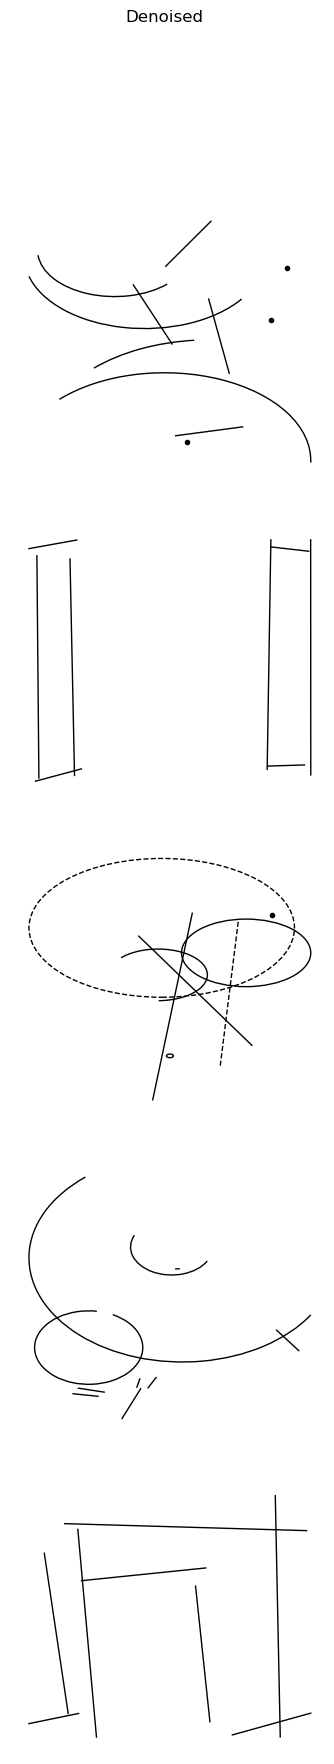

In [24]:
sampler.eval()
with torch.no_grad():
    # graph_idx = 1
    time = 1000
    b = 5
    sampled_latents = torch.randn(b, 1024).to(gpu_id)
    # sampled_nodes = sqrt_a_bar[time,None,None] * nodes[graph_idx].unsqueeze(0) + sqrt_b_bar[time,None,None] * node_noise
    # sampled_edges = sqrt_a_bar[time,None,None,None] * edges[graph_idx].unsqueeze(0) + sqrt_b_bar[time,None,None,None] * edge_noise

    seed = sampled_latents.clone()

    # SketchDataset.render_graph(sampled_nodes[0].cpu().squeeze(0), sampled_edges[0].cpu().squeeze(0), axes[0])

    for i in reversed(range(1,time)):
        denoised_latent = sampler(sampled_latents, torch.tensor([i]).to(gpu_id).expand(b))
        
        denoised_latent_mean = (sqrt_a_bar[i - 1] * (1 - a[i]) * denoised_latent + a[i].sqrt() * (1 - a_bar[i - 1]) * sampled_latents) / (1 - a_bar[i])# (sampled_latents - pred_noise * (1 - a[i]) / sqrt_b_bar[i]) / sqrt_a[i]

        assert denoised_latent_mean.isfinite().all()

        if i > 1:
            noise = torch.randn_like(sampled_latents).to(gpu_id)

            sampled_latents = denoised_latent_mean + (1 - a[i]).sqrt() * noise
        else:
            sampled_latents = denoised_latent_mean

    assert sampled_latents.isfinite().all()

    fig, axes = plt.subplots(nrows = b, ncols = 1, figsize=(4, b * 4))
    fig.suptitle(f"Denoised")
    for i in range(b):
        nodes, edges = vae.decoder(sampled_latents)
        SketchDataset.render_graph(nodes[i].cpu().squeeze(0), edges[i].cpu().squeeze(0), axes[i])

In [15]:
from datetime import datetime, timezone

torch.save(seed[2], f"seeds/{datetime.now(timezone.utc)}")